# Imports

In [29]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd

In [25]:
print(os.listdir("./chest_xray"))

['test', 'train', 'val']


# Data Loading

In [26]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to train, test, or val directory.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Define label mapping manually
        self.class_to_idx = {"NORMAL": 0, "PNEUMONIA": 1}

        # Iterate through NORMAL and PNEUMONIA folders
        for label_name in ["NORMAL", "PNEUMONIA"]:
            label_dir = os.path.join(root_dir, label_name)
            for file_name in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file_name)
                
                # Ensure it's an image file (basic check)
                if file_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(file_path)
                    self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        """Returns total number of images"""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Loads and returns an image and its label"""
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert("L")  # Convert to grayscale as this is XRAY and that should be plenty

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((320, 320)),  # Resize images
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize assuming 1 channel
])

# Define dataset paths
data_dir = "./chest_xray"
train_path, test_path, val_path = os.path.join(data_dir, "train"), os.path.join(data_dir, "test"), os.path.join(data_dir, "val")

# Create datasets
train_dataset = ChestXrayDataset(train_path, transform=transform)
test_dataset = ChestXrayDataset(test_path, transform=transform)
val_dataset = ChestXrayDataset(val_path, transform=transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify the dataset
print(f"Total training images: {len(train_dataset)}")
print(f"Total test images: {len(test_dataset)}")
print(f"Total validation images: {len(val_dataset)}")

# Check a batch
images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")  # Should be [batch_size, 1, 224, 224]
print(f"Batch labels: {labels}")  # Labels should be tensor of 0s and 1s


Total training images: 5216
Total test images: 624
Total validation images: 16
Batch image shape: torch.Size([32, 1, 224, 224])
Batch labels: tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1])


# Exploratory Data Analysis

## View Some Images

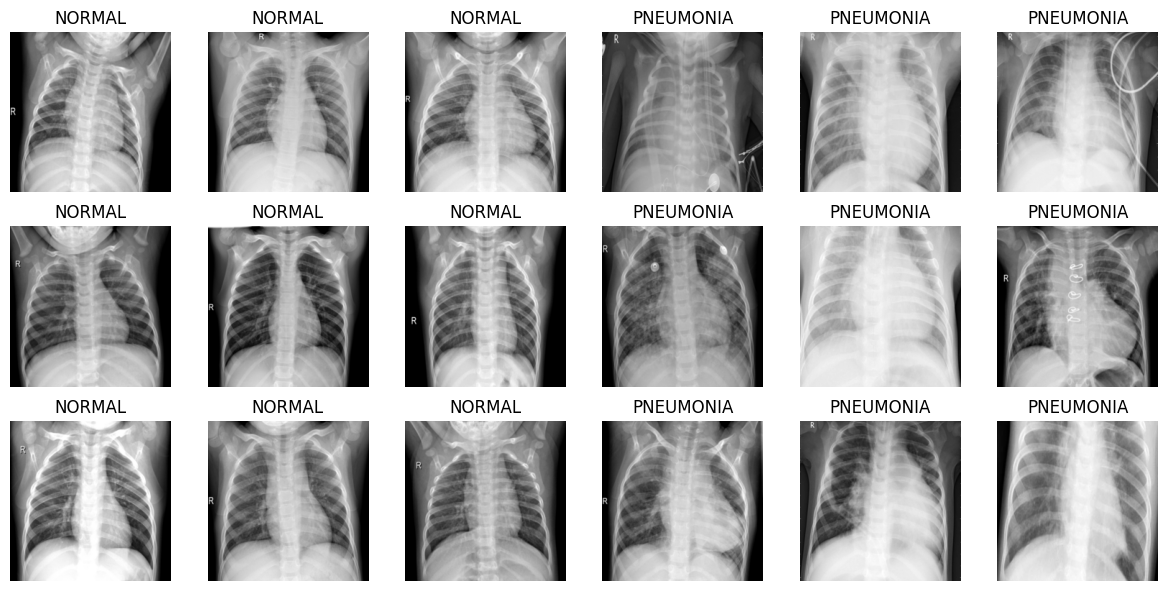

In [28]:

# Reverse class mapping
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

num_images_per_class = 9
normal_images, pneumonia_images = [], []

for xb, yb in train_loader:
    for i in range(len(yb)):  # Iterate over batch
        img = xb[i].squeeze(0)  # Remove channel dimension
        label = yb[i].item()
        class_name = idx_to_class[label]

        if class_name == "NORMAL" and len(normal_images) < num_images_per_class:
            normal_images.append(img)
        elif class_name == "PNEUMONIA" and len(pneumonia_images) < num_images_per_class:
            pneumonia_images.append(img)

        # Stop once we have enough images
        if len(normal_images) == num_images_per_class and len(pneumonia_images) == num_images_per_class:
            break
    if len(normal_images) == num_images_per_class and len(pneumonia_images) == num_images_per_class:
        break

# Create a 3x6 plot
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12, 6))

# Plot images
for i in range(9):
    # NORMAL images (First 3 columns)
    axes[i // 3, i % 3].imshow(normal_images[i], cmap="gray")
    axes[i // 3, i % 3].set_title("NORMAL")
    
    # PNEUMONIA images (Next 3 columns)
    axes[i // 3, i % 3 + 3].imshow(pneumonia_images[i], cmap="gray")
    axes[i // 3, i % 3 + 3].set_title("PNEUMONIA")

# Remove axes
for ax in axes.flat:
    ax.axis("off")

plt.tight_layout()
plt.show()


# Visualize Distribution of Classes

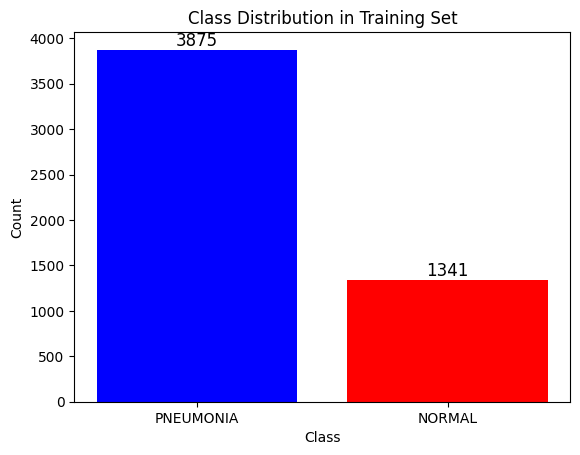

In [34]:
train_labels = []

for xb, yb in train_loader:
    train_labels.extend(yb.detach().numpy())
    
label_counts = pd.Series(train_labels).value_counts().rename(index={0: "NORMAL", 1: "PNEUMONIA"})

fig, ax = plt.subplots()
bars = ax.bar(label_counts.index, label_counts.values, color=["blue", "red"])

# Add values on top of bars
for bar in bars:
    height = bar.get_height()  # Get bar height (count value)
    ax.text(bar.get_x() + bar.get_width()/2, height, f"{int(height)}", ha='center', va='bottom', fontsize=12)

ax.set_title("Class Distribution in Training Set")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.show()
    